In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Neste trabalho, buscamos determinar as características durante uma partida do jogo eletrônico, League of Legends, que ocasiona a vitória.

# 1. Problema a ser resolvido:
* ### Predizer o resultado de uma partida do jogo eletrônico League of Legends, será vitória ou derrota.
* ### Neste trabalho, será utilizado Classificação para determinar se aquele time venceu ou perdeu a partida

# 2. Datasets Originais
* O dataset conta com os arquivos: champs.csv, matches.csv, participants.csv, stats1.csv, stats2.csv, teamstats.csv, teambans.csv.
    - teambans.csv não foi utilizado, pois o banimento não influência o que acontece durante o jogo em si, então não será analisado. 
* A quantidade de tuplas de cada arquivo está destacado na seção de análise exploratória dos dados
* Tamanho dos Datasets: 695 MB
* 85 features e 1 label **(Win)**
* Link: https://www.kaggle.com/paololol/league-of-legends-ranked-matches/data

# 3. Descrição das Principais Features / Atributos de cada tabela
* ### Tabela Campeões (champs.csv)
    - name - Possui o nome de cada campeão (String, unique, 138)
    - id - Um identificador único para cada campeão (varia de 1 a 516)
* ### Tabela Partidas (matches.csv)
    - id - Identificador da partida (Varia de 10 até 187588)
    - gameid - Identificador do jogo
    - platformid - Região ('EUW1', 'NA1', 'EUN1', 'TR1') - (Europe West, North America, Europe Nordic and East, Turkey)
    - queueid - Tipo da Partida (420, 440, 410,   4,  42,   9,  41) 
    - seasonid - Identificador da temporada (Varia de 3 até 8)
    - duration - Duração da partida (segundos, varia de 190 até 4991)
    - creation - Data da criação da partida (timestamp)
    - version - versão do patch, versão do jogo (String can repeat)
* ### Tabela Participantes (participants.csv)
    - id - Chave estrangeira para a chave primária da tabela stats1 / stats2
    - matchid - Chave estrangeira para a chave primária da tabela matches
    - player - Identificador do jogador na partida (1-5 time azul, 6-10 time vermelho)
    - championid - Chave estrangeira para a chave primária da tabela champs
    - ss1 - Feitiço no D
    - ss2 - Feitiço no F
    - role - Lane, none é jg ('NONE' 'DUO_SUPPORT' 'DUO_CARRY' 'SOLO' 'DUO') 
    - position - Posição ('JUNGLE' 'BOT' 'TOP' 'MID') 
* ### Tabela Estatísticas (stats1.csv e stats2.csv)
    - id - Identificador único para a estatistica
    - **win** - Vitória ou Derrota (0 ou 1)
    - ... (Outros atributos são referentes a partida)
* ### Tabela Estatísticas do Time (teamstats.csv)
    - matchid - Chave estrangeira para a chave primária da tabela matches
    - teamid - Identificador do time (100 para time azul e 200 para time vermelho)
    - firstblood - Quem matou o primeiro (0 ou 1)
    - firsttower - Quem destruiu a primeira torre (0 ou 1)
    - firstinhib - Quem destruiu o primeiro inibidor (0 ou 1)
    - firstbaron - Quem matou o primeiro barão (0 ou 1)
    - firstdragon - Quem matou o primeiro dragão (0 ou 1)
    - firstharry - Quem matou o arauto (0 ou 1)
    - towerkills - Quantas torres destruiu
    - inhibkills - Quantos inibidores destruiu
    - baronkills - Quantos barões matou
    - dragonkills - Quantos dragões matou
    - harrykills - Quantos arautos matou

# 4. Carregamento dos Dados / Análise Exploratória dos dados

### Tabela Campeões (champs.csv)

In [2]:
# campeões
champs = pd.read_csv('champs.csv')
champs.shape
#champs.loc[champs['id'] == 19]
#champs = champs.sort_index(1)
#champs = champs.sort_values(by=['id'])
#champs.values

(138, 2)

In [3]:
champs.head()

,name,id
0,Jax,24
1,Sona,37
2,Tristana,18
3,Varus,110
4,Fiora,114


### Tabela Partidas (matches.csv)

In [4]:
# partidas
matches = pd.read_csv('matches.csv')
matches.shape

(184069, 8)

In [5]:
matches.head()

,id,gameid,platformid,queueid,seasonid,duration,creation,version
0,10,3187427022,EUW1,420,8,1909,1495068946860,7.10.187.9675
1,11,3187425281,EUW1,420,8,1693,1495066760778,7.10.187.9675
2,12,3187269801,EUW1,420,8,1482,1495053375889,7.10.187.9675
3,13,3187252065,EUW1,420,8,1954,1495050993613,7.10.187.9675
4,14,3187201038,EUW1,420,8,2067,1495047893400,7.10.187.9675


### Tabela Participantes (participants.csv)

In [6]:
# participantes
participants = pd.read_csv('participants.csv')
participants.shape

(1834520, 8)

In [7]:
participants.head(10)

,id,matchid,player,championid,ss1,ss2,role,position
0,9,10,1,19,4,11,NONE,JUNGLE
1,10,10,2,267,3,4,DUO_SUPPORT,BOT
2,11,10,3,119,7,4,DUO_CARRY,BOT
3,12,10,4,114,12,4,SOLO,TOP
4,13,10,5,112,4,3,SOLO,MID
5,14,10,6,72,11,4,NONE,JUNGLE
6,15,10,7,3,4,12,SOLO,TOP
7,16,10,8,103,14,4,SOLO,MID
8,17,10,9,222,7,4,DUO_CARRY,BOT
9,18,10,10,161,14,4,DUO_SUPPORT,BOT


### Tabela Estatísticas (stats1.csv e stats2.csv)

In [8]:
# dataset 1 representando a metade das partidas
stats1 = pd.read_csv('stats1.csv')
stats1.shape

(999999, 56)

In [9]:
# dataset 2 representando a outra metade das partidas
stats2 = pd.read_csv('stats2.csv', low_memory=False)
stats2.shape

(834518, 56)

In [10]:
# Juntando os datasets
stats = stats1.append(stats2)
stats.shape
#stats.columns

(1834517, 56)

In [11]:
stats.head(10)

,id,win,item1,item2,item3,item4,item5,item6,trinket,kills,...,neutralminionskilled,ownjunglekills,enemyjunglekills,totcctimedealt,champlvl,pinksbought,wardsbought,wardsplaced,wardskilled,firstblood
0,9,0,3748,2003,3111,3053,1419,1042,3340,6,...,69,42,27,610,13,0,0,10,0,0
1,10,0,2301,3111,3190,3107,0,0,3364,0,...,1,1,0,211,14,1,0,17,3,0
2,11,0,1055,3072,3006,3031,3046,1036,3340,7,...,3,1,2,182,14,1,0,13,5,0
3,12,0,1029,3078,3156,1001,3053,0,3340,5,...,6,6,0,106,15,0,0,3,0,0
4,13,0,3020,1058,3198,3102,1052,1026,3340,2,...,4,3,1,159,15,0,0,10,0,0
5,14,1,1400,3111,3078,3742,1033,3067,3340,3,...,111,81,30,808,16,0,0,8,2,0
6,15,1,3025,3193,3068,3047,1028,3082,3363,4,...,6,0,6,179,16,1,0,7,0,0
7,16,1,3135,3165,3089,3020,1058,3136,3340,13,...,6,3,3,48,17,0,0,8,0,0
8,17,1,3046,3031,3006,3085,3072,1029,3340,15,...,7,2,5,440,16,1,0,6,1,1
9,18,1,1058,2045,3092,3089,3113,3158,3364,4,...,2,1,1,260,16,5,0,25,7,0


### Tabela Estatísticas dos Times (teamstats.csv)

In [12]:
tstats = pd.read_csv('teamstats.csv')
tstats.teamid = tstats.teamid.div(100)
tstats.shape

(368138, 13)

In [13]:
tstats.head()

,matchid,teamid,firstblood,firsttower,firstinhib,firstbaron,firstdragon,firstharry,towerkills,inhibkills,baronkills,dragonkills,harrykills
0,10,1.0,0,1,0,0,0,0,5,0,0,0,0
1,10,2.0,1,0,1,1,1,1,10,3,1,3,1
2,11,1.0,1,0,0,0,0,0,2,0,0,0,0
3,11,2.0,0,1,1,0,1,0,10,3,0,2,0
4,12,1.0,1,0,0,0,0,0,1,0,0,0,0


# 5. Verificação da existência de valores nulos
#### Através das verificações abaixo, não teremos nenhum problema com relação aos valores nulos

In [14]:
# Para a tabela champs
print(champs.shape)
champs.count()

(138, 2)


name    138
id      138
dtype: int64

In [15]:
# Para a tabela matches
print(matches.shape)
matches.count()

(184069, 8)


id            184069
gameid        184069
platformid    184069
queueid       184069
seasonid      184069
duration      184069
creation      184069
version       184069
dtype: int64

In [16]:
# Para a tabela participants
print(participants.shape)
participants.count()

(1834520, 8)


id            1834520
matchid       1834520
player        1834520
championid    1834520
ss1           1834520
ss2           1834520
role          1834520
position      1834520
dtype: int64

In [17]:
# Para a tabela stats
print(stats.shape)
stats.count()

(1834517, 56)


id                        1834517
win                       1834517
item1                     1834517
item2                     1834517
item3                     1834517
item4                     1834517
item5                     1834517
item6                     1834517
trinket                   1834517
kills                     1834517
deaths                    1834517
assists                   1834517
largestkillingspree       1834517
largestmultikill          1834517
killingsprees             1834517
longesttimespentliving    1834517
doublekills               1834517
triplekills               1834517
quadrakills               1834517
pentakills                1834517
legendarykills            1834517
totdmgdealt               1834517
magicdmgdealt             1834517
physicaldmgdealt          1834517
truedmgdealt              1834517
largestcrit               1834517
totdmgtochamp             1834517
magicdmgtochamp           1834517
physdmgtochamp            1834517
truedmgtochamp

In [18]:
# Para a tabela tstats
print(tstats.shape)
tstats.count()

(368138, 13)


matchid        368138
teamid         368138
firstblood     368138
firsttower     368138
firstinhib     368138
firstbaron     368138
firstdragon    368138
firstharry     368138
towerkills     368138
inhibkills     368138
baronkills     368138
dragonkills    368138
harrykills     368138
dtype: int64

# 6. Unindo as tabelas (Merge)
Participantes é a principal com a chave estrangeira de champs, matches, stats, enquanto irei adiciona a matches a tabela tstats

* ### Tabela Campeões (champs.csv)
   - id - Um identificador único para cada campeão (varia de 1 a 516)
* ### Tabela Partidas (matches.csv)
    - id - Identificador da partida (Varia de 10 até 187588)
* ### Tabela Participantes (participants.csv)
    - id - Chave estrangeira para a chave primária da tabela stats1 / stats2
    - matchid - Chave estrangeira para a chave primária da tabela matches
    - championid - Chave estrangeira para a chave primária da tabela champs
* ### Tabela Estatísticas (stats1.csv e stats2.csv)
    - id - Identificador único para a estatistica
* ### Tabela Estatísticas do Time (teamstats.csv)
    - teamid - Chave estrangeira para a chave primária da tabela matches

### 1º Passo = Unir algumas das tabelas para facilitar

In [19]:
# participants e stats
df = pd.merge(participants, stats, how = 'left', on = ['id'], suffixes=('', '_y'))
# df com champs
df = pd.merge(df, champs, how = 'left', left_on = 'championid', right_on = 'id', suffixes=('', '_champ'))
# df com matches
df = pd.merge(df, matches, how = 'left', left_on = 'matchid', right_on = 'id', suffixes=('', '_y'))

In [20]:
df.shape

(1834520, 73)

### 2º Passo = Pré-processamento dos dados
* Possuimos em *participants* os atributos **role** e **position**, onde os dois tentam dizer qual o local que o jogador irá jogar e qual a função do jogador no jogo, mas só é necessário dizer qual a função dele no jogo, só que **role** não consegue dizer sozinho, tornando-se necessário criar uma função para determinar isso.
* Também é necessário atualizar os times, pois temos que a feature **player** vai de 1 até 10, o que apenas importa é sabe se é do time azul (1 a 5) ou vermelho (6 a 10). Criamos uma função para dizer 1 se é azul ou 2 se é vermelho. Também é necessário criar uma feature para determinar a função + time
* Houve casos em que o BOT não é especificado, então será necessário remover. Essa é quando é DUO em role e BOT em position. Existem alguns casos de existir duplicados, por exemplo, 3 Mid no mesmo time.


- Atributos retirados: 'item1', 'item2', 'item3', 'item4', 'item5','item6', 'trinket','largestkillingspree', 'largestmultikill', 'killingsprees', 'longesttimespentliving', 'legendarykills','plataformid', 'queueid', 'seasonid',

In [21]:
# AQUI ESTÁ SENDO MODIFICADO ROLE E POSITION PARA FINALPOSITION
print(participants.role.unique())
print(participants.position.unique())

# Função para o apply
# No final, ficará apenas Jungle, Top, Mid, Duo_support, Duo_carry
def final_position(row):
    if (row['role'] in ('DUO_SUPPORT', 'DUO_CARRY')):
        return row['role']
    else:
        return row['position']

df['finalposition'] = df.apply(final_position, axis = 1)

['NONE' 'DUO_SUPPORT' 'DUO_CARRY' 'SOLO' 'DUO']
['JUNGLE' 'BOT' 'TOP' 'MID']


In [22]:
# AQUI ESTÁ SENDO MODIFICADO PLAYER PARA TEAM
df['team'] = df['player'].apply(lambda x : '1' if x <= 5 else '2')
# Determinar o time + posição de cada jogador
df['team_role'] = df['team'] + ' - ' + df['finalposition']
#df.loc[pd.isnull(df.win) == True]

In [23]:
# AQUI ESTÁ SENDO CONSERTADO ALGUMAS FALHAS DO REALIZADO ACIMA
df.team_role.unique()

remove_index = []
for i in ('1 - JUNGLE', '1 - DUO_SUPPORT', '1 - DUO_CARRY', '1 - TOP',
       '1 - MID', '2 - JUNGLE', '2 - TOP', '2 - MID', '2 - DUO_CARRY',
       '2 - DUO_SUPPORT'):
    df_remove = df[df['team_role'] == i].groupby('matchid').agg({'team_role':'count'})
    remove_index.extend(df_remove[df_remove['team_role'] != 1].index.values)

In [24]:
remove_index.extend(df[df['finalposition'] == 'BOT']['matchid'].unique())
remove_index = list(set(remove_index))
df.dropna(inplace=True)

print('# Partidas no dataset antes da limpeza: {}'.format(df['matchid'].nunique()))
df = df[~df['matchid'].isin(remove_index)]
print('# Partidas no dataset depois da limpeza: {}'.format(df['matchid'].nunique()))

# Partidas no dataset antes da limpeza: 184069
# Partidas no dataset depois da limpeza: 148638


In [25]:
# UNINDO A ÚLTIMA TABELA QUE FALTA (Temos que mudar o tipo de object to float64)
df.team = df.team.astype(np.float64)
df = pd.merge(df, tstats, how = 'left', left_on = ['team', 'matchid'], right_on = ['teamid', 'matchid'], suffixes=('', '_y'))
df.firstbaron = df.firstbaron.astype(np.uint8)
df.firstblood = df.firstblood.astype(np.uint8)
df.firstdragon = df.firstdragon.astype(np.uint8)
df.firstharry = df.firstharry.astype(np.uint8)
df.firstinhib = df.firstinhib.astype(np.uint8)
df.firsttower = df.firsttower.astype(np.uint8)
df.win = df.win.astype(np.uint8)
#df.kills.describe()
#df['kills'] = df['kills'].apply(lambda x: x if x<16 else 16)
#df['kills'] = df['kills'].apply(lambda x: x if x>0 else 0)

# 7. Escolha / Remoção das feautres
* Os ids repetidos (id_y), queueid, item (1 a 6), trinket, foram retirados
    * Item (1 a 6) foi retirado, pois os itens são sempre atualizados a cada versão, atrapalhando as análises
    * trinket foi retirado, mesmo caso do item
* sequência de "kills" não serão utilizados, pois não decidem diretamente o destino do jogo, existirá milhares de casos que um time com várias sequências de kills não ganha, são: 'largestkillingspree', 'largestmultikill', 'killingsprees', 'longesttimespentliving', 'legendarykills', 'creation'
* finalposition foi divido em 5 features

In [26]:
df.columns.values

array(['id', 'matchid', 'player', 'championid', 'ss1', 'ss2', 'role',
       'position', 'win', 'item1', 'item2', 'item3', 'item4', 'item5',
       'item6', 'trinket', 'kills', 'deaths', 'assists',
       'largestkillingspree', 'largestmultikill', 'killingsprees',
       'longesttimespentliving', 'doublekills', 'triplekills',
       'quadrakills', 'pentakills', 'legendarykills', 'totdmgdealt',
       'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit',
       'totdmgtochamp', 'magicdmgtochamp', 'physdmgtochamp',
       'truedmgtochamp', 'totheal', 'totunitshealed', 'dmgselfmit',
       'dmgtoobj', 'dmgtoturrets', 'visionscore', 'timecc', 'totdmgtaken',
       'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'goldearned',
       'goldspent', 'turretkills', 'inhibkills', 'totminionskilled',
       'neutralminionskilled', 'ownjunglekills', 'enemyjunglekills',
       'totcctimedealt', 'champlvl', 'pinksbought', 'wardsbought',
       'wardsplaced', 'wardskilled', 'firstblood'

In [27]:
df = df[['id', 'matchid', 'player', 'championid', 'ss1', 'ss2', 'finalposition', 'team',
       'win', 'kills', 'deaths', 'assists', 'doublekills', 'triplekills','quadrakills', 'pentakills',
        'totdmgdealt', 'magicdmgdealt', 'physicaldmgdealt', 'truedmgdealt', 'largestcrit',
       'totdmgtochamp', 'magicdmgtochamp', 'physdmgtochamp',
       'truedmgtochamp', 'totheal', 'totunitshealed', 'dmgselfmit',
       'dmgtoobj', 'dmgtoturrets', 'visionscore', 'timecc', 'totdmgtaken',
       'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'goldearned',
       'goldspent',  'turretkills', 'inhibkills', 'totminionskilled',
       'neutralminionskilled', 'ownjunglekills', 'enemyjunglekills',
       'totcctimedealt', 'champlvl', 'pinksbought', 'wardsbought',
       'wardsplaced', 'wardskilled', 'firstblood', 'name',
       'gameid', 'seasonid', 'duration', 'version', 'firsttower', 'firstinhib', 'firstbaron',
       'firstdragon', 'firstharry', 'towerkills','baronkills', 'dragonkills', 'harrykills']]

In [28]:
new = pd.get_dummies(df[['finalposition']])
df = pd.concat([df, new], axis=1)
df = df.drop(['finalposition'], axis=1)

In [29]:
df.head()

,id,matchid,player,championid,ss1,ss2,team,win,kills,deaths,...,firstharry,towerkills,baronkills,dragonkills,harrykills,finalposition_DUO_CARRY,finalposition_DUO_SUPPORT,finalposition_JUNGLE,finalposition_MID,finalposition_TOP
0,9,10,1,19,4,11,1.0,0,6.0,10.0,...,0,5,0,0,0,0,0,1,0,0
1,10,10,2,267,3,4,1.0,0,0.0,2.0,...,0,5,0,0,0,0,1,0,0,0
2,11,10,3,119,7,4,1.0,0,7.0,8.0,...,0,5,0,0,0,1,0,0,0,0
3,12,10,4,114,12,4,1.0,0,5.0,11.0,...,0,5,0,0,0,0,0,0,0,1
4,13,10,5,112,4,3,1.0,0,2.0,8.0,...,0,5,0,0,0,0,0,0,1,0


# 8. Correlação
* Através de uma análise inicial das correlações, foram removidos aqueles inicias que possuem uma correlação com o rótulo menor que 0.10

Removidos: ['truedmgtochamp', 'ss1', 'ss2', 'totdmgdealt',  'truedmgdealt', 'team', 'firstblood', 
            'totdmgtaken', 'magicdmgtaken', 'physdmgtaken', 'truedmgtaken', 'triplekills', 'quadrakills', 
             'pentakills', 'magicdmgdealt','physicaldmgdealt','totcctimedealt', 'magicdmgtochamp', 'physdmgtochamp', 'visionscore', 'pinksbought', 'wardsplaced', 'wardskilled', 'duration', 'totminionskilled', 'championid']
             
* Algo notável nesse ponto, foi que, no jogo, a visão é um fator essência destacado, mas percebemos que sua correlação é muito baixa com o nosso rótulo

In [30]:
df_c = df[['win', 'kills', 'deaths', 'assists', 'doublekills' ,'totdmgtochamp','totheal', 'totminionskilled',
 'goldearned', 'goldspent', 'totdmgtaken', 'turretkills', 'inhibkills',
 'champlvl', 'firsttower', 'firstinhib', 'firstbaron', 'firstdragon', 'firstharry', 'towerkills',
 'baronkills', 'dragonkills', 'harrykills','duration', 'finalposition_DUO_CARRY', 'finalposition_DUO_SUPPORT', 'finalposition_JUNGLE',
 'finalposition_MID', 'finalposition_TOP']]

Text(0.5,1,'Correlação - win e features')

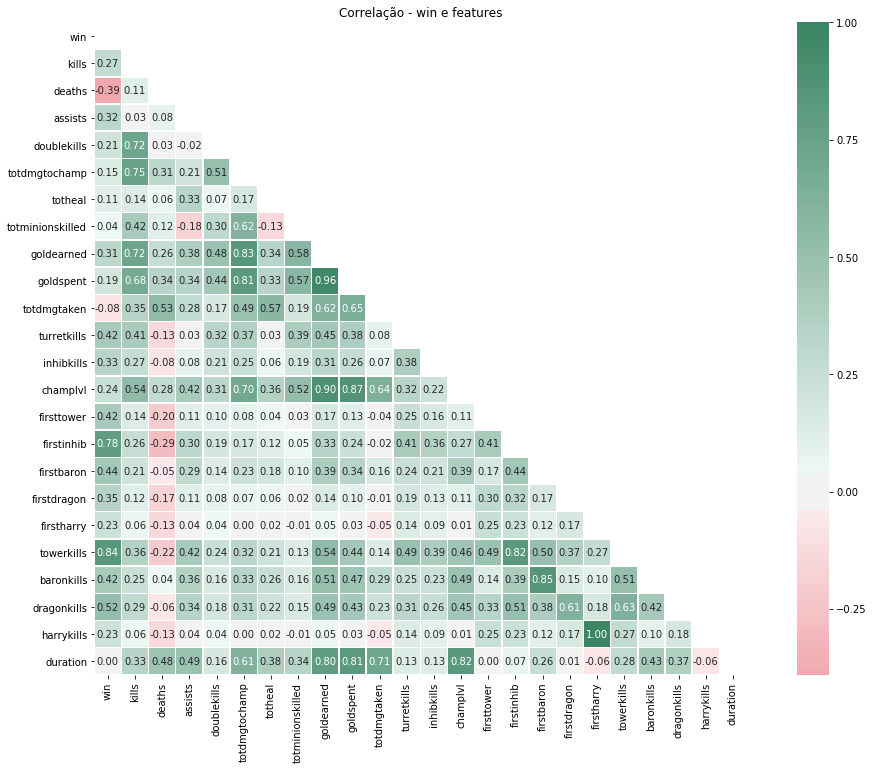

In [31]:
df_corr = df_c._get_numeric_data()
df_corr = df_corr.drop(['finalposition_DUO_CARRY', 'finalposition_DUO_SUPPORT', 'finalposition_JUNGLE',
 'finalposition_MID', 'finalposition_TOP'], axis = 1)

mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 150, as_cmap=True)

plt.figure(figsize = (18,12))
sns.heatmap(df_corr.corr(), cmap = cmap, annot = True, fmt = '.2f', mask = mask, square=True, linewidths=.5, center = 0)
plt.title('Correlação - win e features')

# 9. Iniciando Classificação dos dados com grupo de 50000 tuplas
### As 28 Features Escolhidas:
* kills, deaths, assists, doublekills ,totdmgtochamp,totheal, totminionskilled, goldearned, goldspent, totdmgtaken, turretkills, inhibkills, champlvl, firsttower, firstinhib, firstbaron, firstdragon, firstharry, towerkills, baronkills, dragonkills, harrykills,duration, finalposition_DUO_CARRY, finalposition_DUO_SUPPORT, finalposition_JUNGLE, finalposition_MID, finalposition_TOP

### Técnicas Escolhidas:
* KNeighborsClassifier
* BernoulliNB
* GradientBoostingClassifier
* RandomForestClassifier
* LogisticRegression
* SVC
* DecisionTreeClassifier

### Métricas de Avaliação Escolhidas:
* Accuracy
* Precision
* Recall
* F1

In [32]:
temp = df.head(50000)

In [33]:
X = temp[['kills', 'deaths', 'assists', 'doublekills' ,'totdmgtochamp','totheal', 'totminionskilled',
 'goldearned', 'goldspent', 'totdmgtaken', 'turretkills', 'inhibkills',
 'champlvl', 'firsttower', 'firstinhib', 'firstbaron', 'firstdragon', 'firstharry', 'towerkills',
 'baronkills', 'dragonkills', 'harrykills','duration', 'finalposition_DUO_CARRY', 'finalposition_DUO_SUPPORT', 'finalposition_JUNGLE',
 'finalposition_MID', 'finalposition_TOP']]

y = temp['win']

In [34]:
X.head()

,kills,deaths,assists,doublekills,totdmgtochamp,totheal,totminionskilled,goldearned,goldspent,totdmgtaken,...,towerkills,baronkills,dragonkills,harrykills,duration,finalposition_DUO_CARRY,finalposition_DUO_SUPPORT,finalposition_JUNGLE,finalposition_MID,finalposition_TOP
0,6.0,10.0,1.0,2.0,9101.0,15160.0,42.0,10497.0,10275.0,41446.0,...,5,0,0,0,1909,0,0,1,0,0
1,0.0,2.0,12.0,0.0,8478.0,11707.0,17.0,9496.0,7975.0,17769.0,...,5,0,0,0,1909,0,1,0,0,0
2,7.0,8.0,5.0,2.0,14425.0,2283.0,205.0,13136.0,11775.0,25627.0,...,5,0,0,0,1909,1,0,0,0,0
3,5.0,11.0,2.0,0.0,15267.0,4252.0,164.0,11006.0,10683.0,31705.0,...,5,0,0,0,1909,0,0,0,0,1
4,2.0,8.0,2.0,0.0,18229.0,1525.0,235.0,11439.0,10485.0,20585.0,...,5,0,0,0,1909,0,0,0,1,0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

In [36]:
#KNeighborsClassifier
model_KNN = KNeighborsClassifier(n_neighbors=25)
model_KNN.fit(X_train, y_train)
y_pred_KNN = model_KNN.predict(X_test)

#BernoulliNB
model_BNB = BernoulliNB()
model_BNB.fit(X_train, y_train)
y_pred_BNB = model_BNB.predict(X_test)

#GradientBoostingClassifier
model_GBC = GradientBoostingClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=0)
model_GBC.fit(X_train, y_train)
y_pred_GBC = model_GBC.predict(X_test)

#RandomForestClassifier
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
model_RFC.fit(X_train, y_train)
y_pred_RFC = model_RFC.predict(X_test)

#LogisticRegression
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)

#DecisionTreeClassifier
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_train, y_train)
y_pred_DTC = model_DTC.predict(X_test)

In [37]:
print('Accuracy: ')
print('KNeighborsClassifier: {}'.format(metrics.accuracy_score(y_test, y_pred_KNN)))
print('BernoulliNB: {}'.format(metrics.accuracy_score(y_test, y_pred_BNB)))
print('GradientBoostingClassifier: {}'.format(metrics.accuracy_score(y_test, y_pred_GBC)))
print('RandomForestClassifier: {}'.format(metrics.accuracy_score(y_test, y_pred_RFC)))
print('LogisticRegression: {}'.format(metrics.accuracy_score(y_test, y_pred_LR)))
print('DecisionTreeClassifier: {}'.format(metrics.accuracy_score(y_test, y_pred_DTC)))


print('\n\nPrecision: ')
print('KNeighborsClassifier: {}'.format(metrics.precision_score(y_test, y_pred_KNN)))
print('BernoulliNB: {}'.format(metrics.precision_score(y_test, y_pred_BNB)))
print('GradientBoostingClassifier: {}'.format(metrics.precision_score(y_test, y_pred_GBC)))
print('RandomForestClassifier: {}'.format(metrics.precision_score(y_test, y_pred_RFC)))
print('LogisticRegression: {}'.format(metrics.precision_score(y_test, y_pred_LR)))
print('DecisionTreeClassifier: {}'.format(metrics.precision_score(y_test, y_pred_DTC)))


print('\n\nRecall: ')
print('KNeighborsClassifier: {}'.format(metrics.recall_score(y_test, y_pred_KNN)))
print('BernoulliNB: {}'.format(metrics.recall_score(y_test, y_pred_BNB)))
print('GradientBoostingClassifier: {}'.format(metrics.recall_score(y_test, y_pred_GBC)))
print('RandomForestClassifier: {}'.format(metrics.recall_score(y_test, y_pred_RFC)))
print('LogisticRegression: {}'.format(metrics.recall_score(y_test, y_pred_LR)))
print('DecisionTreeClassifier: {}'.format(metrics.recall_score(y_test, y_pred_DTC)))


print('\n\nF1: ')
print('KNeighborsClassifier: {}'.format(metrics.f1_score(y_test, y_pred_KNN)))
print('BernoulliNB: {}'.format(metrics.f1_score(y_test, y_pred_BNB)))
print('GradientBoostingClassifier: {}'.format(metrics.f1_score(y_test, y_pred_GBC)))
print('RandomForestClassifier: {}'.format(metrics.f1_score(y_test, y_pred_RFC)))
print('LogisticRegression: {}'.format(metrics.f1_score(y_test, y_pred_LR)))
print('DecisionTreeClassifier: {}'.format(metrics.f1_score(y_test, y_pred_DTC)))

Accuracy: 
KNeighborsClassifier: 0.7618666666666667
BernoulliNB: 0.8809333333333333
GradientBoostingClassifier: 0.9721333333333333
RandomForestClassifier: 0.9635333333333334
LogisticRegression: 0.9596
DecisionTreeClassifier: 0.9548


Precision: 
KNeighborsClassifier: 0.7575399947547863
BernoulliNB: 0.865532241555783
GradientBoostingClassifier: 0.9667809122066966
RandomForestClassifier: 0.94898618106677
LogisticRegression: 0.9561937533086289
DecisionTreeClassifier: 0.9571160546770303


Recall: 
KNeighborsClassifier: 0.7702666666666667
BernoulliNB: 0.902
GradientBoostingClassifier: 0.9778666666666667
RandomForestClassifier: 0.9797333333333333
LogisticRegression: 0.9633333333333334
DecisionTreeClassifier: 0.9522666666666667


F1: 
KNeighborsClassifier: 0.7638503239455243
BernoulliNB: 0.8833899190389135
GradientBoostingClassifier: 0.9722921914357683
RandomForestClassifier: 0.9641146755887948
LogisticRegression: 0.959750265674814
DecisionTreeClassifier: 0.954685202513033


In [42]:
# A feature mais importante é a 'towerkills'
model_GBC.feature_importances_

array([0.01777947, 0.04655727, 0.02782237, 0.00603397, 0.02557377,
       0.02861124, 0.01838528, 0.03931427, 0.04947004, 0.03785682,
       0.00688371, 0.00330567, 0.01240932, 0.00938788, 0.01001072,
       0.00675699, 0.00598071, 0.00419974, 0.44289449, 0.01659197,
       0.02538619, 0.00254994, 0.1494718 , 0.00172113, 0.00123603,
       0.00059171, 0.00124879, 0.0019687 ])

# 10. Modelo Final usando o GradientBoostingClassifier

In [38]:
X = df[['kills', 'deaths', 'assists', 'doublekills' ,'totdmgtochamp','totheal', 'totminionskilled',
 'goldearned', 'goldspent', 'totdmgtaken', 'turretkills', 'inhibkills',
 'champlvl', 'firsttower', 'firstinhib', 'firstbaron', 'firstdragon', 'firstharry', 'towerkills',
 'baronkills', 'dragonkills', 'harrykills','duration', 'finalposition_DUO_CARRY', 'finalposition_DUO_SUPPORT', 'finalposition_JUNGLE',
 'finalposition_MID', 'finalposition_TOP']]

y = df['win']

In [41]:
y_pred = model_GBC.predict(X)

In [42]:
print('Accuracy: ')
print('GradientBoostingClassifier: {}'.format(metrics.accuracy_score(y, y_pred)))

print('\nPrecision: ')
print('GradientBoostingClassifier: {}'.format(metrics.precision_score(y, y_pred)))

print('\nRecall: ')
print('GradientBoostingClassifier: {}'.format(metrics.recall_score(y, y_pred)))

print('\nF1: ')
print('GradientBoostingClassifier: {}'.format(metrics.f1_score(y, y_pred)))

Accuracy: 
GradientBoostingClassifier: 0.9587791374762087

Precision: 
GradientBoostingClassifier: 0.9431774165455675

Recall: 
GradientBoostingClassifier: 0.9763811948400049

F1: 
GradientBoostingClassifier: 0.9594921326712158


In [43]:
#GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
model = GradientBoostingClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [44]:
print('Accuracy: ')
print('GradientBoostingClassifier: {}'.format(metrics.accuracy_score(y_test, y_pred)))

print('\nPrecision: ')
print('GradientBoostingClassifier: {}'.format(metrics.precision_score(y_test, y_pred)))

print('\nRecall: ')
print('GradientBoostingClassifier: {}'.format(metrics.recall_score(y_test, y_pred)))

print('\nF1: ')
print('GradientBoostingClassifier: {}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 
GradientBoostingClassifier: 0.9690698529741562

Precision: 
GradientBoostingClassifier: 0.963465543984046

Recall: 
GradientBoostingClassifier: 0.9751159431990456

F1: 
GradientBoostingClassifier: 0.9692557355707928


In [ ]:
# Modelo Final
model_final = GradientBoostingClassifier(n_estimators=50, max_depth=10, learning_rate=0.1, random_state=0)
model_final.fit(X, y)

# X. Determinando os melhores parâmetros para os modelos

In [ ]:
#Escolhendo o melhor n_neighbors para KNN
values = [5, 10, 15, 20, 25, 30]
for i in values:
    model_KNN = KNeighborsClassifier(n_neighbors=i)
    model_KNN.fit(X_train, y_train)
    y_pred_KNN = model_KNN.predict(X_test)
    print('Accuracy para n_neighbors {} = {}'.format(i, metrics.accuracy_score(y_test, y_pred_KNN)))

In [ ]:
#Escolhendo os melhores parâmetros para GradientBoostingClassifier
values_n_estimators = [50, 100, 200]
values_learning_rate = [0.1, 0.05, 0.01]
values_max_depth = [3, 5, 7, 10]


for i in values_n_estimators:
    for j in values_max_depth:
        for k in values_learning_rate:
            accuracy = []
            precision = []
            recall = []
            f1_measure = []


            model_GBC = GradientBoostingClassifier(n_estimators=i, max_depth=j, learning_rate=k, random_state=0)
            model_GBC.fit(X_train, y_train)
            y_pred_GBC = model_GBC.predict(X_test)
            accuracy.append(metrics.accuracy_score(y_test, y_pred_GBC))
            precision.append(metrics.precision_score(y_test, y_pred_GBC))
            recall.append(metrics.recall_score(y_test, y_pred_GBC))
            f1_measure.append(metrics.f1_score(y_test, y_pred_GBC))
        
            print("N_estimators " + str(i) + " ----- Max_depth " + str(j) + " ----- Learning_rate " + str(k))
            print("Accuracy: " + str(np.mean(accuracy)))
            print("Precision: " + str(np.mean(precision)))
            print("Recall: " + str(np.mean(recall)))
            print("F1: " + str(np.mean(f1_measure)))
            print("\n ------------------------- \n")

In [ ]:
#Escolhendo os melhores parâmetros para RandomForestClassifier
values_n_estimators = [50, 100, 200]
values_max_depth = [3, 5, 7]


for i in values_n_estimators:
    for j in values_max_depth:
        accuracy = []
        precision = []
        recall = []
        f1_measure = []


        model_RFC = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=0)
        model_RFC.fit(X_train, y_train)
        y_pred_RFC = model_RFC.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred_RFC))
        precision.append(metrics.precision_score(y_test, y_pred_RFC))
        recall.append(metrics.recall_score(y_test, y_pred_RFC))
        f1_measure.append(metrics.f1_score(y_test, y_pred_RFC))
        
        print("N_estimators " + str(i) + " ----- Max_depth " + str(j))
        print("Accuracy: " + str(np.mean(accuracy)))
        print("Precision: " + str(np.mean(precision)))
        print("Recall: " + str(np.mean(recall)))
        print("F1: " + str(np.mean(f1_measure)))
        print("\n ------------------------- \n")

# X. Visualização Extra

Text(0.5,1,'Visão Colocada (wardsplaced) pela temporada (seasonid): vitória (win) vs derrota (loss)')

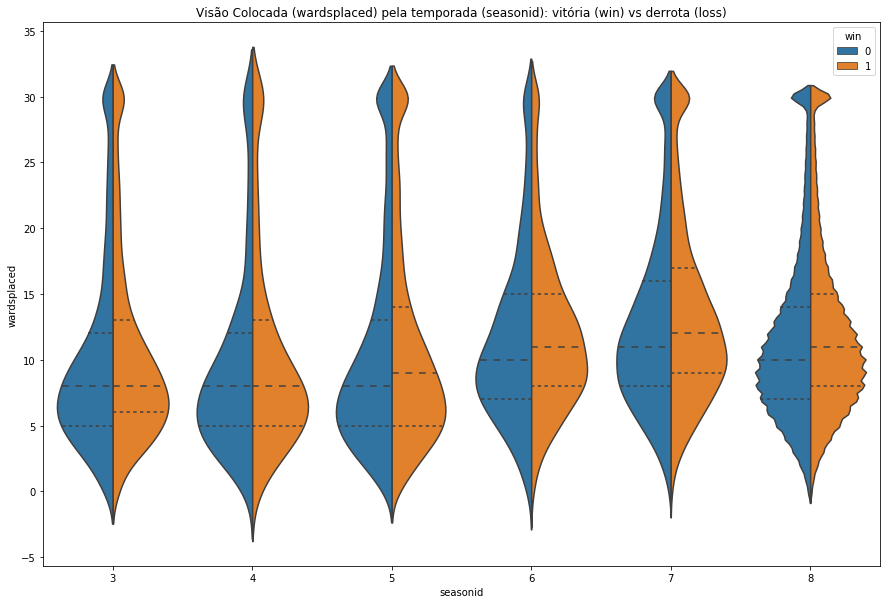

In [35]:
#df_wards = df.copy()

#plt.figure(figsize = (15,10))
#sns.barplot(x="seasonid", y="wardsplaced", hue="win", data=df_wards)
#plt.title('Wardsplaced by season: win vs loss')




# Uma plotagem de violino mostra a distribuição de uma única variável numérica e transmite a densidade da distribuição
#baseada em um kernel mais suave que indica a densidade de valores (via largura) do campo numérico
#plt.figure(figsize = (15,10))
#sns.violinplot(x="seasonid", y="wardsplaced", hue="win", data=df_wards)
#plt.title('Wardsplaced by season: win vs loss')



#plt.figure(figsize = (15,10))
#sns.boxplot(x="seasonid", y="wardsplaced", hue="win", data=df_wards)
#plt.title('Wardsplaced by season: win vs loss')



# Uma plotagem de violino mostra a distribuição de uma única variável numérica e transmite a densidade da distribuição
#baseada em um kernel mais suave que indica a densidade de valores (via largura) do campo numérico
# inner : {“box”, “quartile”, “point”, “stick”, None}, optional
#plt.figure(figsize = (15,10))
#sns.violinplot(x="seasonid", y="wardsplaced", hue="win", data=df_wards, split=True, inner='quartile')
#plt.title('Wardsplaced by season: win vs loss')




# Uma plotagem de violino mostra a distribuição de uma única variável numérica e transmite a densidade da distribuição
#baseada em um kernel mais suave que indica a densidade de valores (via largura) do campo numérico
# inner : {“box”, “quartile”, “point”, “stick”, None}, optional
#df.wardsplaced.describe()
df['wardsplaced'] = df['wardsplaced'].apply(lambda x: x if x<30 else 30)
df['wardsplaced'] = df['wardsplaced'].apply(lambda x: x if x>0 else 0)
plt.figure(figsize = (15,10))
sns.violinplot(x="seasonid", y="wardsplaced", hue="win", data=df, split=True, inner = 'quartile')
plt.title('Visão Colocada (wardsplaced) pela temporada (seasonid): vitória (win) vs derrota (loss)')

In [37]:
pd.options.display.float_format = '{:,.1f}'.format

df_win_rate = df.groupby('name').agg({'win': 'sum', 'name': 'count', 'kills': 'mean', 'deaths': 'mean', 'assists': 'mean'})
df_win_rate.columns = ['win matches', 'total matches', 'K', 'D', 'A']
df_win_rate['win rate'] = df_win_rate['win matches'] /  df_win_rate['total matches'] * 100
df_win_rate['KDA'] = (df_win_rate['K'] + df_win_rate['A']) / df_win_rate['D']
df_win_rate = df_win_rate.sort_values('win rate', ascending = False)
df_win_rate = df_win_rate[['total matches', 'win rate', 'K', 'D', 'A', 'KDA']]
print('Top 10 win rate')
print(df_win_rate.head(10))
print('Bottom 10 win rate')
print(df_win_rate.tail(10))

Top 10 win rate
          total matches  win rate   K   D    A  KDA
name                                               
Ivern              6671      55.9 2.6 4.2 13.3  3.8
Anivia             6433      54.0 6.4 4.8  7.5  2.9
Xerath             5108      53.6 7.3 5.4  8.6  2.9
Ahri              30840      53.5 7.3 5.6  7.7  2.7
Sona              11847      53.1 3.0 5.7 13.9  2.9
Skarner            1720      53.1 4.8 5.0  9.2  2.8
Zilean             4797      53.0 3.2 4.7 11.9  3.2
KogMaw             6440      52.7 7.9 6.6  7.1  2.3
Janna             21182      52.7 0.9 4.0 14.5  3.8
Pantheon           8872      52.6 8.1 6.5  6.8  2.3
Bottom 10 win rate
         total matches  win rate   K   D    A  KDA
name                                              
Nidalee           4520      46.6 7.0 6.1  7.3  2.3
LeBlanc           8690      46.6 8.0 5.9  6.1  2.4
Zed              17687      46.4 8.5 6.5  5.7  2.2
Jhin             11240      46.4 7.1 5.9  8.6  2.6
Poppy             5165      46.3 4.

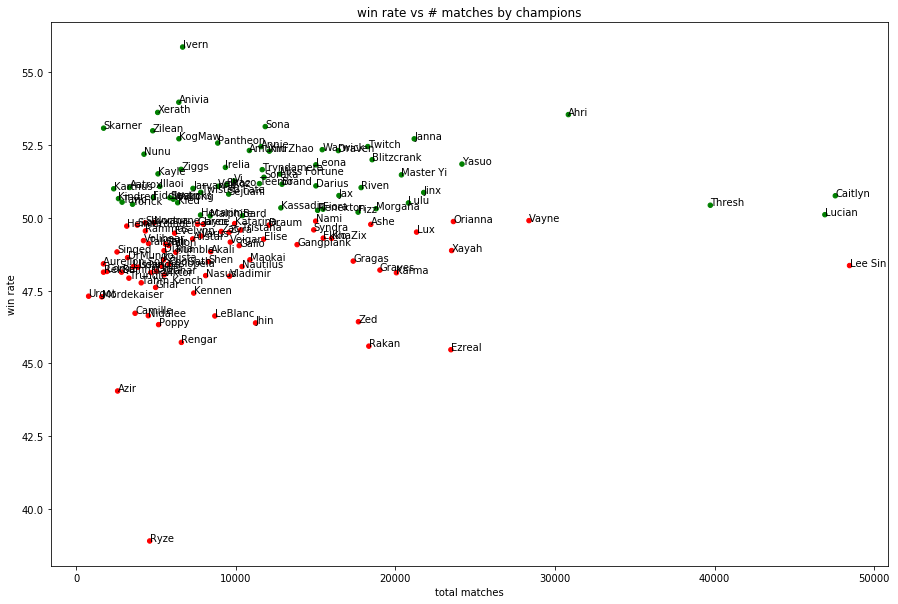

In [38]:
df_win_rate.reset_index(inplace = True)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

df_win_rate['color map'] = df_win_rate['win rate'].apply(lambda x: 'green' if x > 50 else 'red')

ax = df_win_rate.plot(kind = 'scatter', x = 'total matches', y = 'win rate', color = df_win_rate['color map'].tolist(), figsize = (15,10), title = 'win rate vs # matches by champions')

label_point(df_win_rate['total matches'], df_win_rate['win rate'], df_win_rate['name'], ax)

# Finalização
### Dificuldades: 
* Alta quantidade de tuplas
* Muitas features

### Aprendizados:
* Trabalhar com grande quantidade de dados
* Processamento dos dados

### Melhorias futuras:
* Standizar os dados e testar
* Testar o modelo final para novos dados
* Realizar uma análise com um foco em poucas features